# C.3. Treasury Arbitrage in the Financial Crisis of 2008

## FINM 37400 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

### Reference

For more context on this discussion, see the following HBS Cases:
* Fixed Income Arbitrage in a Financial Crisis (A): US Treasuries in November 2008
* Fixed Income Arbitrage in a Financial Crisis (B): US Treasuries in December 2008

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

In [2]:
import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *

### Other functions

These functions are not published, thus you will not be able to re-run this code.

In [3]:
from tradebondpair import *

***

# The Data

In [4]:
filepath_tsdata = f'../data/treasury_ts_2015-08-15.xlsx'
info = pd.read_excel(filepath_tsdata,sheet_name='info',index_col=0)
tsdata = pd.read_excel(filepath_tsdata,sheet_name='database')
tsdata.columns = tsdata.columns.str.upper()

In [5]:
DATE0 = '2008-11-04'
tab = get_table(info,tsdata,DATE0)
tab

kytreasno,204046,204047
issue date,1985-08-15 00:00:00,2005-08-15 00:00:00
maturity date,2015-08-15 00:00:00,2015-08-15 00:00:00
coupon rate,10.625,4.25
type,bond,note
bid,141.859375,105.953125
ask,141.890625,105.984375
accrued interest,2.338655,0.935462
clean price,141.875,105.96875
dirty price,144.213655,106.904212
duration,5.230138,5.935706


## Financing Assumptions

The market rates are listed in the table below.

In [6]:
financing = pd.DataFrame(dtype='float64',index=['long','short'])
financing['haircut'] = [.02,.02]
financing['repo'] = [.0015,.0010]
financing

,haircut,repo
long,0.02,0.0015
short,0.02,0.0010


### Long and Short ID

We long the bond with the higher YTM.

We short the bond with the lower YTM.

In [7]:
keyLong = tab.loc['ytm'].astype('float64').idxmax()
keyShort = tab.loc['ytm'].astype('float64').idxmin()

# Sizing the Position

### Calculating Hedge Ratio

Notation:
* $n_i$: number of bonds purchased (or sold)
* $D_i$: duration of bond $i$
* $D_{\$,i}$: dollar duration of bond $i$, equal to $p_iD_i$

If we want the total duration of our holdings to be zero, then we need to size the trade such that $n_i$ and $n_j$ satisfy,

$$0 = n_iD_{\$,i} + n_jD_{\$,j}$$

$$n_j = -n_i\frac{D_{\$,i}}{D_{\$,j}}$$

### Balance sheet of trade for long $1mm position of trader's capital (equity)

* leverage at haircut to get larger long position
* set short position to keep duration at zero
* calculate how much of the short position comes from trader's capital (equity) using short haircut rate

The assumed sizing of the long position is $1mm long in equity.

In [8]:
LONGEQUITY = 1e6

balsheet, fmt = trade_balance_sheet(prices=tab.loc['dirty price'], durations=tab.loc['duration'], haircuts=financing['haircut'], long_equity=LONGEQUITY, key_long=keyLong, key_short=keyShort)
balsheet.style.format(fmt,na_rep='')

,equity,assets,contracts
204046,"$1,000,000.00","$50,000,000.00","346,707.81"
204047,"$-881,131.58","$-44,056,578.93","-412,112.66"


# Profit Opportunity

### The Current Situation

Spread had widened enormously, no trade, then contracted.

But now it has spread out once again to nearly 35bps.

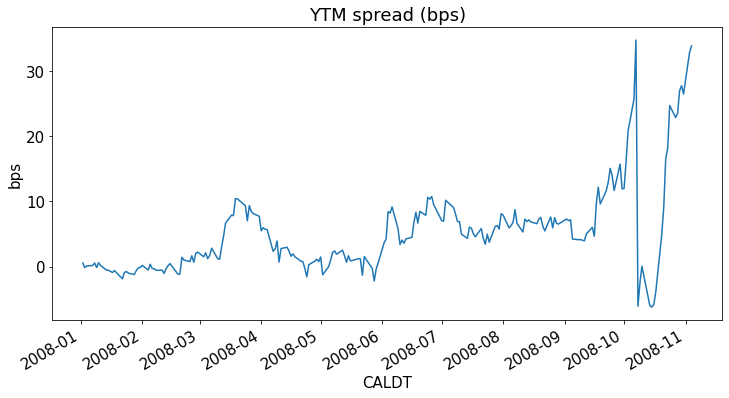

In [9]:
spread = get_spread_bps(tsdata)
spread = spread[keyShort]
spread.rename('ytm spread (bps)',inplace=True)
spread.loc['2008':'2008-11-04'].plot(ylabel='bps',title='YTM spread (bps)');

### Scenario: Spread disappears, as ytm converge to midpoint

In [10]:
spread_convergence = tab.loc['ytm'].diff().dropna().abs().values[0]

pnl_spread_converges, fmt_dict = pnl_spread_trade(spread_convergence,tab.loc['modified duration'], tab.loc['dirty price'], balsheet['contracts'])
pnl_spread_converges.style.format(fmt_dict,na_rep='')

,ytm change,modified duration,price,contracts,pnl
kytreasno,,,,,
204046,-0.1695%,5.14,$144.21,"346,707.81","$435,509.58"
204047,0.1695%,5.84,$106.90,"-412,112.66","$436,236.08"
total,,,,,"$871,745.67"


### Scenario: 1bp narrowing of spread, as ytm of each moves half that much

In [11]:
spread_convergence = .0001

pnl_spread_1bp, fmt_dict = pnl_spread_trade(spread_convergence,tab.loc['modified duration'], tab.loc['dirty price'], balsheet['contracts'])
pnl_spread_1bp.style.format(fmt_dict,na_rep='')

,ytm change,modified duration,price,contracts,pnl
kytreasno,,,,,
204046,-0.0050%,5.14,$144.21,"346,707.81","$12,845.71"
204047,0.0050%,5.84,$106.90,"-412,112.66","$12,867.14"
total,,,,,"$25,712.85"


In [12]:
opportunity = pd.DataFrame([pnl_spread_converges.loc['total','pnl'], pnl_spread_1bp.loc['total','pnl']], columns=['pnl'],index=['converges','1bp'])
opportunity['return'] = opportunity['pnl'] / balsheet['equity'].abs().sum()
opportunity.style.format({'return':'{:.2%}','pnl':'${:,.2f}'})

,pnl,return
converges,"$871,745.67",46.34%
1bp,"$25,712.85",1.37%


# Examine the Trade's Performance

Get timeseries of the dirty price and duration for use in assessing other dates.

In [13]:
ask = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDASK')
bid = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDBID')
accint = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDACCINT')
dirty = (ask + bid)/2 + accint
dirty = dirty[[keyLong,keyShort]]

duration = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDDURATN')[[keyLong,keyShort]] / 365.25

## Through 2008

Look ahead 9 weeks.

### Calculating profit and loss (pnl)
In general, look at both
* the price changes to the bonds held
* coupon payments

Simpler here,
* No coupon being paid in November or December; thus easy to just check price changes of the bonds.

Does the total pnl react to the spread in bps as we estimated above?

In [14]:
n_weeks = 9
trade, fmt_dict = trade_evolution(DATE0, tab.loc['maturity date',keyShort], n_weeks, balsheet, dirty, duration, financing, tab.loc['coupon rate'], keyLong, keyShort)

summary = trade[['price change','coupons','total pnl']].join(spread,how='left')

fmt = fmt_dict
fmt['ytm spread (bps)'] = '{:.2f}'
summary.style.format(fmt,na_rep='')

,price change,coupons,total pnl,ytm spread (bps)
2008-11-04 00:00:00,$0.00,$0.00,$0.00,33.88
2008-11-10 00:00:00,"$-115,883.84",$0.00,"$-115,883.84",38.54
2008-11-18 00:00:00,"$-181,887.02",$0.00,"$-181,887.02",41.15
2008-11-25 00:00:00,"$-499,072.82",$0.00,"$-499,072.82",52.96
2008-12-02 00:00:00,"$-748,066.35",$0.00,"$-748,066.35",61.46
2008-12-09 00:00:00,"$-903,774.22",$0.00,"$-903,774.22",67.29
2008-12-16 00:00:00,"$-1,049,332.75",$0.00,"$-1,049,332.75",71.61
2008-12-23 00:00:00,"$-805,707.20",$0.00,"$-805,707.20",63.50
2008-12-30 00:00:00,"$-756,986.09",$0.00,"$-756,986.09",61.81


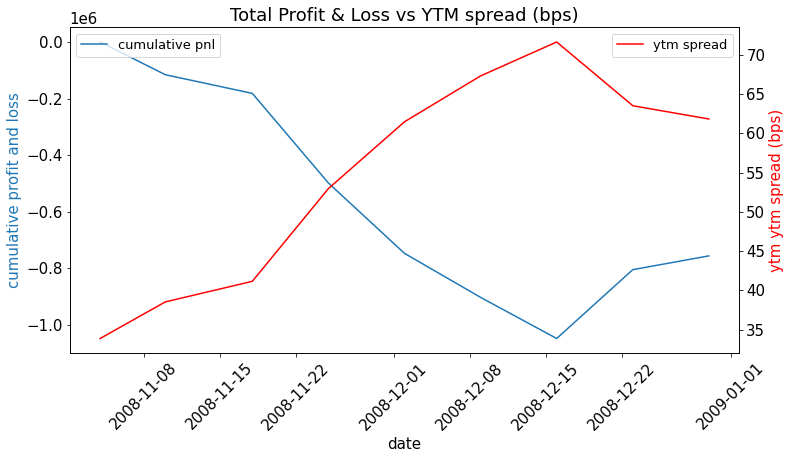

In [15]:
fig, ax = plt.subplots()

ax.plot(summary[['total pnl']])
ax.set_xlabel('date');
ax.set_ylabel('cumulative profit and loss',color=ax.get_lines()[-1].get_color());
ax.tick_params(axis='x', rotation=45)
ax.legend(['cumulative pnl'],loc=2)

ax2 = ax.twinx()
ax2.plot(summary[['ytm spread (bps)']], color='r')
ax2.set_ylabel('ytm ytm spread (bps)',color=ax2.get_lines()[-1].get_color());
ax2.legend(['ytm spread'],loc=1)

ax.set_title('Total Profit & Loss vs YTM spread (bps)');

### Conclusion:

Loses a ton! Loss is roughly what we expected to gain.
* Spread diverges ~35bps instead of converging ~35bps.
* So our estimated pnl response (via modified duration) to ytm spread is reasonable approximation.

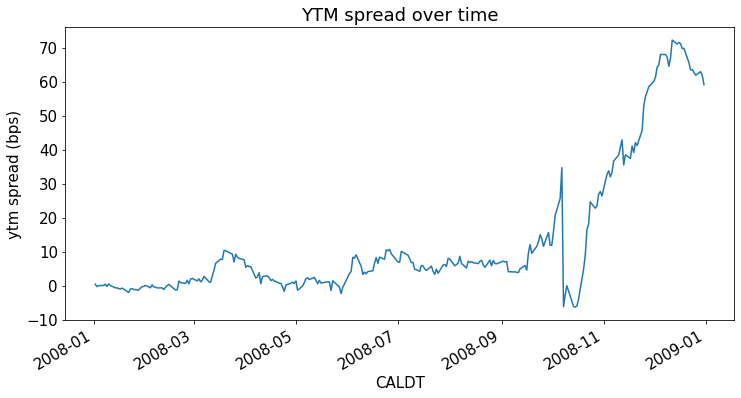

In [16]:
spread.loc['2008'].plot(ylabel='ytm spread (bps)',title='YTM spread over time');

# Longer View

In [17]:
n_weeks = 35
trade_long, fmt_dict = trade_evolution(DATE0, tab.loc['maturity date',keyShort], n_weeks, balsheet, dirty, duration, financing, tab.loc['coupon rate'], keyLong, keyShort)

summary_long = trade_long[['price change','coupons','total pnl']].join(spread,how='left')

fmt = fmt_dict
fmt['ytm spread (bps)'] = '{:.2f}'
summary_long.iloc[::4,:].style.format(fmt,na_rep='')

,price change,coupons,total pnl,ytm spread (bps)
2008-11-04 00:00:00,$0.00,$0.00,$0.00,33.88
2008-12-02 00:00:00,"$-748,066.35",$0.00,"$-748,066.35",61.46
2008-12-30 00:00:00,"$-756,986.09",$0.00,"$-756,986.09",61.81
2009-01-27 00:00:00,"$20,657.36",$0.00,"$20,657.36",35.33
2009-02-24 00:00:00,"$-561,855.73","$966,145.83","$404,290.09",22.07
2009-03-24 00:00:00,"$-545,508.23","$966,145.83","$420,637.60",22.02
2009-04-21 00:00:00,"$-222,863.63","$966,145.83","$743,282.19",10.41
2009-05-19 00:00:00,"$22,192.58","$966,145.83","$988,338.41",1.32
2009-06-16 00:00:00,"$234,164.91","$966,145.83","$1,200,310.74",-7.14


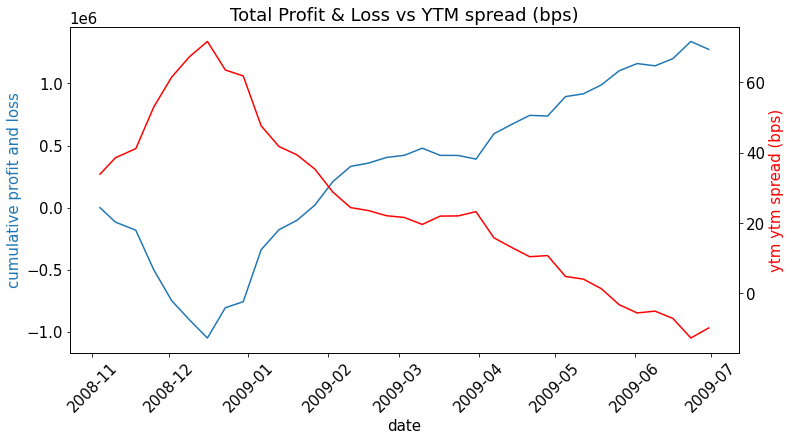

In [18]:
fig, ax = plt.subplots()

ax.plot(summary_long[['total pnl']])
ax.set_xlabel('date');
ax.set_ylabel('cumulative profit and loss',color=ax.get_lines()[-1].get_color());
ax.tick_params(axis='x', rotation=45)

ax2 = ax.twinx()
ax2.plot(summary_long[['ytm spread (bps)']], color='r')
ax2.set_ylabel('ytm ytm spread (bps)',color=ax2.get_lines()[-1].get_color());

ax.set_title('Total Profit & Loss vs YTM spread (bps)');

### It converges!

The trade pays off approximately as expected.
* Actually, a little better given spread goes negative and some nonlinearity in the relationship.

### Was this convergence expected or lucky?

Expected. 
* Look at the history of the ytm spread of these two instruments from 2005 (issuance of the note) through 2014.
* Leave out 2015, as the spread may diverge as the instruments approach maturity.

Figure and table below.

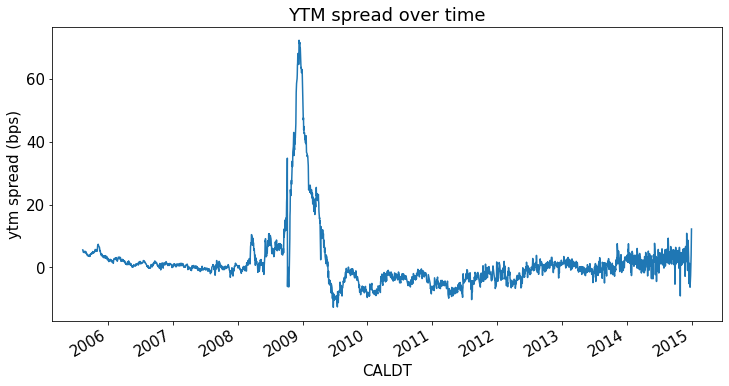

In [19]:
spread.loc['2005':'2014'].plot(ylabel='ytm spread (bps)',title='YTM spread over time');

In [20]:
spread.loc[:'2014'].describe()

count    2349.000000
mean        1.399500
std         9.735221
min       -12.694467
25%        -2.625583
50%         0.108490
75%         1.979015
max        72.309578
Name: ytm spread (bps), dtype: float64

Note:
* On average, only 1.4bps apart!
* Being 2bps apart is a 75th percentile occurence.
* Max divergence (~72bps) is this episode.

So the logic of the trade was reasonable: it was an aberrant spread, and it was expected to converge.

But given it first diverged, it could have led to such large losses as to force exit by the traders.

# Managing Capital

During the first two months of the trade, (Nov and Dec,) it is even worse than indicated by the total PnL above.

The loss in value in the position would trigger a margin call, as the 5\% haircuts would still apply.

Accordingly, the trader would have to either
* wind down a portion of the trade to bring the leverage in line
* put in new equity capital to bring the leverage in line

### Balance sheet and margin calls

The chart below considers the second option, where the trader adds more equity capital to hold on to the original position sizes.

The `margin call` column is written such that a 
* **positive** amount indicates a requirement that more equity capital is contributed
* **negative** amount indicates a distribution of capital back to the trader

In [21]:
trade_long.iloc[::3,2:].style.format(fmt_dict,na_rep='')

,total pnl,equity,margin call,capital paid in,return (init equity),return (avg equity)
2008-11-04 00:00:00,$0.00,"$1,881,131.58",$0.00,"$1,881,131.58",0.00%,0.00%
2008-11-25 00:00:00,"$-499,072.82","$1,941,030.56","$337,456.87","$2,500,002.35",-26.53%,-23.43%
2008-12-16 00:00:00,"$-1,049,332.75","$2,028,766.37","$187,893.41","$3,225,733.91",-55.78%,-41.78%
2009-01-06 00:00:00,"$-338,795.82","$2,020,524.15","$-435,468.35","$2,498,712.53",-18.01%,-13.03%
2009-01-27 00:00:00,"$20,657.36","$2,024,359.34","$-137,846.33","$2,146,929.75",1.10%,0.82%
2009-02-17 00:00:00,"$359,022.20","$1,970,311.49","$-67,861.56","$1,700,469.19",19.09%,15.01%
2009-03-10 00:00:00,"$479,059.54","$1,937,408.85","$-71,756.97","$1,514,626.58",25.47%,21.17%
2009-03-31 00:00:00,"$391,213.50","$1,991,672.37","$39,560.14","$1,710,999.66",20.80%,17.95%
2009-04-21 00:00:00,"$743,282.19","$1,977,652.99","$-85,040.50","$1,330,892.20",39.51%,35.62%
2009-05-12 00:00:00,"$916,842.43","$1,966,305.91","$-19,632.49","$1,134,637.80",48.74%,46.03%


Note that
* during the initial losses, the trader has to add a lot of equity capital

This combination of losing large amounts of money and taking up equity capital might lead it to being closed in November or December, before it has the chance to recover.

See that the returns are worse than -50\% after about a month.
* there is a question of how to measure the returns--on the initial equity capital, or some average of the (variable) equity capital over the holding period. Both columns are shown.

# Caveats

### Dynamic Hedging

We are setting up a zero-duration trade and letting it "ride".

Typically, we would want to re-hedge the duration to zero each day. (The duration of the bonds changes over time, meaning the total position has non-zero duration.)

### Changing Haircuts

For some trades, we might be concerned that the haircuts will change over time, greatly impacting the equity capital required, (or alternatively, liquidating positions.)

For this trade, it is unlikely that the haircut on treasury securities would change for the long position, though it is possible that the cash demanded by the broker for the short position, (the "short" haircut,) could change.

### Liquidation

As the trade conditions worsen, we presume more equity capital is contributed. Another, (and perhaps more likely,) option is that the position would be scaled down to the point that no further equity capital is required. 

This would not greatly change the analysis, except that it would scale down the position exactly at times where the expected return is highest, thus dampening the ability of the trade to recover.

### Financing Costs

There is a small net difference in the interest earned on repo on the long position and (effectively) the reverse repo of the short position.

This financing cost is so small that it does not have a material impact on the analysis above, even in the scenario that the trade stays on for 6 months. 

See an approximation for the annual financing charge below to confirm it is an order magnitude smaller than the profit and loss calculated on the trade. (Just an approximation as it uses the initial asset level for the calculation, rather than dynamically updating the asset levels throughout the trade.)

In [22]:
annual_financing_cost = -(financing['repo'].values * balsheet['assets']).sum()

print(f'Annualized financing cost (via repo) is roughly ${annual_financing_cost:,.2f}')

Annualized financing cost (via repo) is roughly $-30,943.42


So even holding the trade for a full year would not substantially change the total pnl.

### Accrued Interest between execution and clearing

If a transaction is determined end-of-day Nov 4, it will not immediately clear. We might assume it clears on Nov 5. Thus, there will be an extra day of accrued interest in the dirty price. 

For simplicity, we use the accrued interest listed on that date, (in this case, Nov 4,) and do not worry about the potential for additional accrued interest between execution and clearing.